# 6: Histograms

In nearly every High Energy Physics analysis, histograms have their place:
- plotting of variables
- calculating efficiency correction tables (weights)
- performing binned fits

and many more.

Scikit-HEP offers libraries to deal with histograms in Python in a performant way:
[hist](https://hist.readthedocs.io/en/latest/) is a user-friendly analysis library for histograms
and is directly built on top of the workhorse [boost-histogram](https://boost-histogram.readthedocs.io/en/latest/),
which can also be used directly. Hist simply provides more functionality.

They are written by the same authors and can also be used often together.

Both also work well together with mplhep, the plotting library.

In [1]:
# jupyter magic to load the previous data sets
%store -r bkg_df
%store -r mc_df
%store -r data_df

import boost_histogram as bh
import hist
import mplhep
import numpy as np

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7efc85743490>, cbar=<matplotlib.colorbar.Colorbar object at 0x7efc8575e1d0>, text=[])

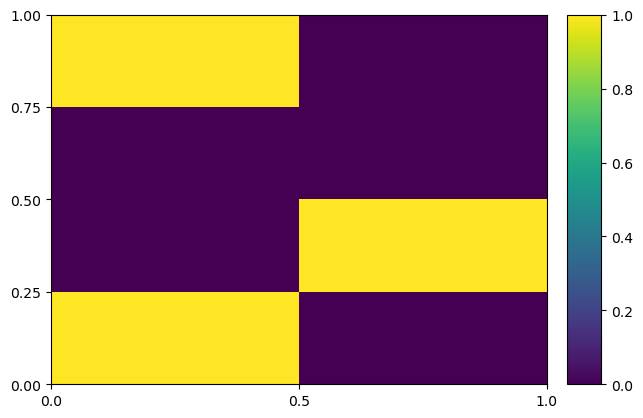

In [2]:
# Let's get started with a simple example

# Compose axis however you like; this is a 2D histogram
h = bh.Histogram(bh.axis.Regular(2, 0, 1),
                 bh.axis.Regular(4, 0.0, 1.0))

# Filling can be done with arrays, one per dimension
h.fill([.3, .5, .2],
          [.1, .4, .9])

# NumPy array view into histogram counts, no overflow bins
counts = h.view()
variances = h.variances()
mplhep.hist2dplot(h)

## Axes

A cental part of a histogram are the axes: They difine the binning and other treats of the axis.

A Hist (*this refers by default to hist.Hist, but usually also applies for bh.Histogram as the former inherits
from the latter*) can have multiple axes of different types.

All axes are described [here](https://hist.readthedocs.io/en/latest/user-guide/axes.html#axes).



The most important types are


### Regular

This is an axis with lower, upper limits, **regularly** split into n bins.

```
axis_reg = hist.axis.Regular(nbins, lower, upper, name=name)
```

### Variable

A variable axis allows to set the bin edges arbitrarily using an array-like object.mro
```
axis_var = hist.axis.Variable([0, 0.5, 3.1, 3.4], name="eta")
```

## Axis Name

An axis (in hist, in bh only a label is possible) have a name, which can be used as the identifier
when working with the histogram (instead of using plain integer indexes).

In [3]:
start, stop = data_df['Jpsi_M'].min(), data_df['Jpsi_M'].max()
axis1 = hist.axis.Regular(bins=50, start=start, stop=stop, name="mass")

To create a histogram, we can pass one or multiple axes to a histogram

In [4]:
data_h = hist.Hist(axis1)

In [5]:
data_h.fill(data_df['Jpsi_M'])

Hist(Regular(50, 2.75, 3.5, name='mass'), storage=Double()) # Sum: 168384.0 (168385.0 with flow)

In [6]:
mc_h = hist.Hist(axis1).fill(mc_df['Jpsi_M'])  # we can also chain the commands

### Compatibility with mplhep

With bh and hist, the [Unified Histogram Interface](https://github.com/scikit-hep/uhi) was also born. This allows objects to be plotted so that a library such as mplhep knows what to do with it.

In short, mplhep and hist work seemless together:

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7efc855ea450>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

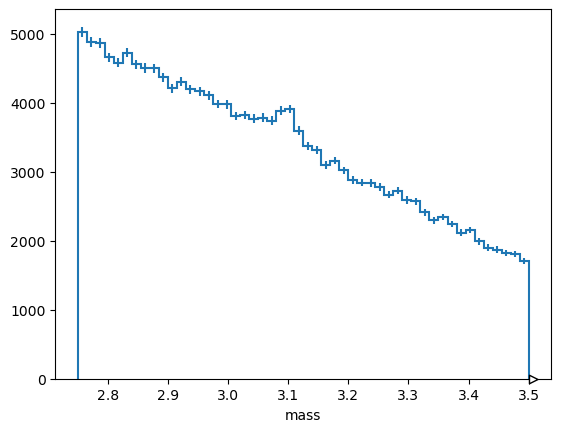

In [7]:
mplhep.histplot(data_h)

### Plotting with hist


hist itself provides also plotting functionality

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7efc57d6d010>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

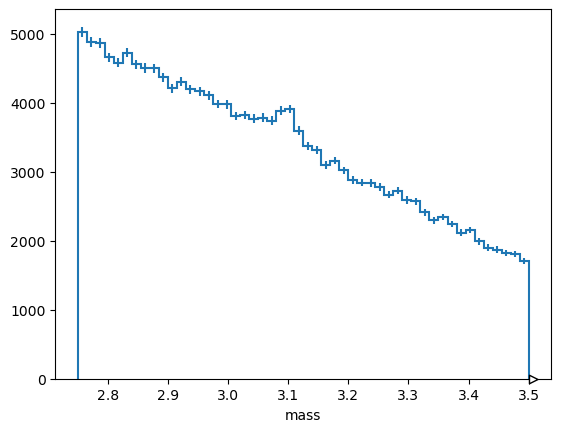

In [8]:
data_h.plot1d()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7efc57bbb990>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

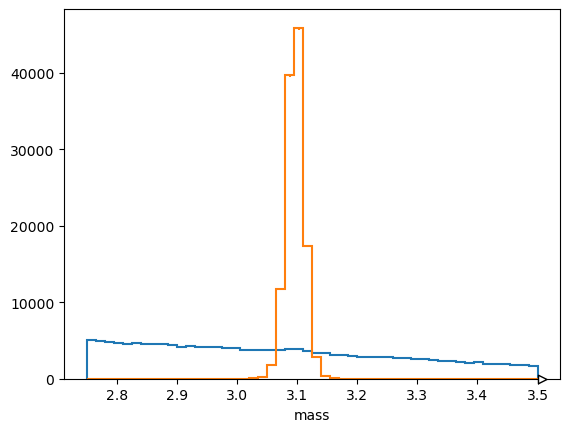

In [9]:
data_h.plot1d()
mc_h.plot1d()

In [10]:
mc_df.columns

Index(['Jpsi_PE', 'Jpsi_PX', 'Jpsi_PY', 'Jpsi_PZ', 'Jpsi_PT', 'Jpsi_P',
       'Jpsi_M', 'mum_PT', 'mum_PX', 'mum_PY', 'mum_PZ', 'mum_IP', 'mum_eta',
       'mum_M', 'mum_PE', 'mup_PT', 'mup_PX', 'mup_PY', 'mup_PZ', 'mup_IP',
       'mup_eta', 'mup_M', 'mup_PE', 'nTracks', 'mum_ProbNNmu', 'mum_ProbNNpi',
       'mup_ProbNNmu', 'mup_ProbNNpi', 'Jpsi_eta', 'mup_P', 'mum_P',
       'catagory', 'BDT'],
      dtype='object')

## Multiple dimensions

Histograms can be multiple dimensional. Let's add a dimension to it.

In [11]:
start, stop = data_df['BDT'].min(), data_df['BDT'].max()
axis_bdt = hist.axis.Regular(bins=20, start=start, stop=stop, name="BDT")

In [12]:
mc_h2d = hist.Hist(axis1, axis_bdt).fill(BDT=mc_df['BDT'], mass=mc_df['Jpsi_M']) # using names

In [13]:
data_h2d = hist.Hist(axis1, axis_bdt)
data_h2d.fill(data_df['Jpsi_M'], data_df['BDT']) # order based

Hist(
  Regular(50, 2.75, 3.5, name='mass'),
  Regular(20, 0.026503, 0.993653, name='BDT'),
  storage=Double()) # Sum: 168383.0 (168385.0 with flow)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7efc57a64790>, cbar=<matplotlib.colorbar.Colorbar object at 0x7efc57c1c210>, text=[])

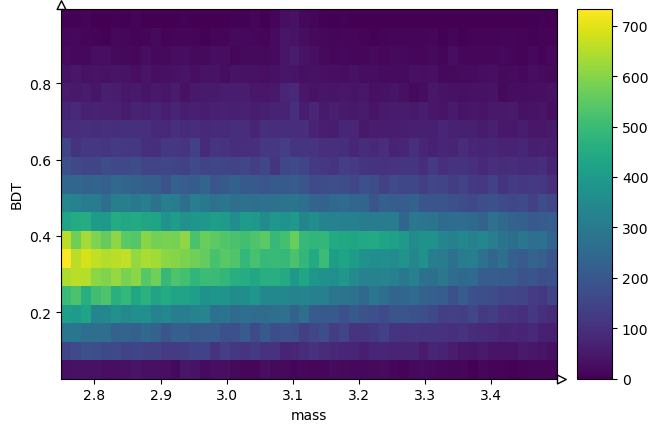

In [14]:
mplhep.hist2dplot(data_h2d)

## Access Bins

hist allows you to access the bins of your Hist by various ways. Besides the normal access by index, you can use locations (supported by boost-histogram), complex numbers, and the dictionary to access the bins.

In [15]:
# Access by bin number
data_h2d[35, 5]

318.0

## Getting Density

If you want to get the density of an existing histogram, .density() is capable to do it and will return you the density array without overflow and underflow bins.

A histogram is a count, so it's an **integral over a density**. To obtain the density, one can devide by the area of the bin, this gives the "average density" in a bin.

In [16]:
data_h2d.density()

array([[0.24562342, 1.20355474, 2.32523501, 3.37322826, 4.07734872,
        5.27271602, 6.00139882, 5.38734028, 3.48785252, 2.77554461,
        1.97317478, 1.4737405 , 1.21992964, 0.7286828 , 0.6058711 ,
        0.42574726, 0.2947481 , 0.17193639, 0.09824937, 0.02456234],
       [0.27018576, 1.34274135, 2.36617225, 3.26679145, 4.2984098 ,
        5.37915283, 5.37915283, 4.68321982, 3.66797636, 2.66092035,
        1.94861244, 1.30999156, 0.87605685, 0.76143259, 0.69593302,
        0.39299747, 0.35206023, 0.13099916, 0.13099916, 0.02456234],
       [0.26199831, 1.46555306, 2.16148607, 3.49603997, 3.76622573,
        5.33002815, 5.6165888 , 5.19084155, 3.68435126, 2.48898396,
        1.85855052, 1.21992964, 0.95793133, 0.83511962, 0.54855896,
        0.42574726, 0.27837321, 0.12281171, 0.08187447, 0.05731213],
       [0.27018576, 1.43280327, 2.14511118, 2.74279482, 4.16741064,
        4.95340558, 5.42827752, 4.83059387, 3.29135379, 2.47260907,
        1.9240501 , 1.23630453, 0.98249367, 0

## Projecting axes

We can also project onto a certain axis

In [17]:
data_h2d.project("mass")  # we will here retain the 1D histogram

Hist(Regular(50, 2.75, 3.5, name='mass'), storage=Double()) # Sum: 168384.0 (168385.0 with flow)

## Accessing everything relevant

Hist is transparent and let's us use many things

In [18]:
data_h2d.axes

(Regular(50, 2.75, 3.5, name='mass'),
 Regular(20, 0.026503, 0.993653, name='BDT'))

In [19]:
data_h2d.axes['mass']

Regular(50, 2.75, 3.5, name='mass')

In [20]:
data_h2d.axes['mass'].edges

array([2.7500011 , 2.76500103, 2.78000096, 2.79500089, 2.81000082,
       2.82500076, 2.84000069, 2.85500062, 2.87000055, 2.88500048,
       2.90000041, 2.91500035, 2.93000028, 2.94500021, 2.96000014,
       2.97500007, 2.99000001, 3.00499994, 3.01999987, 3.0349998 ,
       3.04999973, 3.06499966, 3.0799996 , 3.09499953, 3.10999946,
       3.12499939, 3.13999932, 3.15499925, 3.16999919, 3.18499912,
       3.19999905, 3.21499898, 3.22999891, 3.24499884, 3.25999878,
       3.27499871, 3.28999864, 3.30499857, 3.3199985 , 3.33499843,
       3.34999837, 3.3649983 , 3.37999823, 3.39499816, 3.40999809,
       3.42499803, 3.43999796, 3.45499789, 3.46999782, 3.48499775,
       3.49999768])

In [21]:
data_h2d.axes['mass'].centers  # bin centers

array([2.75750106, 2.772501  , 2.78750093, 2.80250086, 2.81750079,
       2.83250072, 2.84750065, 2.86250059, 2.87750052, 2.89250045,
       2.90750038, 2.92250031, 2.93750024, 2.95250018, 2.96750011,
       2.98250004, 2.99749997, 3.0124999 , 3.02749983, 3.04249977,
       3.0574997 , 3.07249963, 3.08749956, 3.10249949, 3.11749942,
       3.13249936, 3.14749929, 3.16249922, 3.17749915, 3.19249908,
       3.20749902, 3.22249895, 3.23749888, 3.25249881, 3.26749874,
       3.28249867, 3.29749861, 3.31249854, 3.32749847, 3.3424984 ,
       3.35749833, 3.37249826, 3.3874982 , 3.40249813, 3.41749806,
       3.43249799, 3.44749792, 3.46249785, 3.47749779, 3.49249772])

In [22]:
data_h2d.axes['mass'].widths  # bin widths

array([0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993,
       0.01499993, 0.01499993, 0.01499993, 0.01499993, 0.01499993])

### Multi dimensional

All this attributes are also already available in `edges`, they are ready to be broadcasted. So they have the shape of (1, ..., N, ..., 1).

In [23]:
data_h2d.axes.edges
data_h2d.axes['mass'].centers
data_h2d.axes['mass'].widths
areas = np.prod(data_h2d.axes.widths, axis=0)
print(f"areas = {areas}")

areas = [[0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536]
 [0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536]
 [0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536]
 [0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.00072536 0.00072536]
 [0.00072536 0.00072536 0.00072536 0.00072536 0.00072536 0.00072536
  0.0007

**Exercise**: can you obtain the density?

use `hist.values` or `hist.views()`  (the latter makes no copy, the former does).

## Arithmetics

We can use the histograms to do math! We can multiply, add with each other or with scalars.

We can find the ratio between two histograms by dividing them

In [24]:
data_df_bdt = data_df.query("BDT > 0.9")

data_bdt_h2d = hist.Hist(axis1, axis_bdt)
data_bdt_h2d.fill(data_df_bdt['Jpsi_M'], data_df_bdt['BDT']) # order based

Hist(
  Regular(50, 2.75, 3.5, name='mass'),
  Regular(20, 0.026503, 0.993653, name='BDT'),
  storage=Double()) # Sum: 734.0 (735.0 with flow)

In [25]:
ratio = data_bdt_h2d.project("mass") / data_h2d.project("mass")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7efc57ac82d0>, errorbar=None, legend_artist=None)]

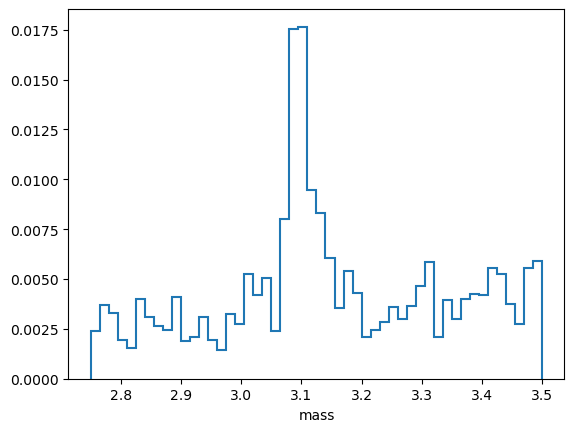

In [26]:
ratio.plot1d()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7efc5496e850>, errorbar=None, legend_artist=None)]

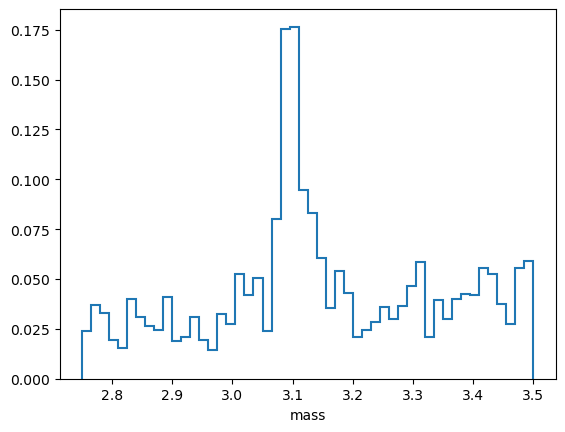

In [27]:
ratio_large = ratio * 10
ratio_large.plot1d()

**Exercise**: use the subtraction to "remove" the signal from the data file using the BDT cut hist. This should be the same as using only "BDT<0.9".

## Weights

Weights are an essential part in HEP histograms and hist fully supports weigths. We can simply give an array of weights when filling the histogram.

We first need to specify the storage type to be of type `Weight` in order to make sure we keep track of the weigths.

In [28]:
weight = np.random.normal(1., 0.1, size=mc_df.shape[0])
storage = hist.storage.Weight()
mc_h2d = hist.Hist(axis1, axis_bdt, storage=storage).fill(BDT=mc_df['BDT'], mass=mc_df['Jpsi_M'], weight=weight) # using names

In [29]:
mc_h2d

Hist(
  Regular(50, 2.75, 3.5, name='mass'),
  Regular(20, 0.026503, 0.993653, name='BDT'),
  storage=Weight()) # Sum: WeightedSum(value=119944, variance=121129) (WeightedSum(value=120004, variance=121190) with flow)

In [30]:
mc_h2d.variances()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000

**Exercise**: implement a function that calculates a weighted chi2 using two histograms.